In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

import urllib.request, json
import requests
import urllib.parse
import datetime

# Script Objective

This notebook aims to reconstruct the daily jail population in New York City's DOC facilities using reports daily admissions and discharges as well as an initial daily jail population metric from the Vera Institute's [Daily Population Trends Dashboard](https://greaterjusticeny.vera.org/nycjail/)



### Socrata API urls:

* Inmate Admission: `https://data.cityofnewyork.us/resource/6teu-xtgp.json`

* Inmate Discharges: `https://data.cityofnewyork.us/resource/94ri-3ium.json`

Both of these datasets are unique on the inmate identification number `INMATEID`. We are going to count the number of inmates admitted and discharges daily from 2016 to May 1, 2023 using the SODA SQL language.


### Initial Jail Population Information:

**Initial Date:** 2014-11-01

**Initial Population:** 11,090

**Secondary Date:** 2019-10-07

**Secondary Population:** 7,225

Source: https://criminaljustice.cityofnewyork.us/wp-content/uploads/2019/10/The-Jail-Population-in-NYC-3300-by-2026.pdf


### Daily Jail Population Equation:

$$ 
p_t = p_{t-1} + a_t - d_t
$$

where $p_t$ is the population at some time $t$, $p_{t-1}$ is the population at the previous timestep, and $a_t, d_t$ are the admissions and discharges at time $t$, respectively.

In [2]:
admit_url = 'https://data.cityofnewyork.us/resource/6teu-xtgp.json'
dis_url = 'https://data.cityofnewyork.us/resource/94ri-3ium.json'

def get_data(url,date_column,startdatetime,enddatetime):
    query = (url+'?'
            "$select=*"
            "&$where=%s between '"+startdatetime+"' and '"+enddatetime+"'"
            "&$limit=500000")%(date_column)
    query = query.replace(" ", "%20")
    print(query)
    response = urllib.request.urlopen(query)
    data = json.loads(response.read())
    
    #store in dataframe
    df = pd.DataFrame(data,columns = data[0].keys())
    
    return df

In [64]:
admissions = get_data(admit_url,'admitted_dt','2014-11-01T00:00:00.000', '2023-05-31T00:00:00.000')
admissions.head()

https://data.cityofnewyork.us/resource/6teu-xtgp.json?$select=*&$where=admitted_dt%20between%20'2014-11-01T00:00:00.000'%20and%20'2023-05-31T00:00:00.000'&$limit=500000


,inmateid,admitted_dt,discharged_dt,race,gender,inmate_status_code,top_charge
0,10008773,2018-08-23T10:15:28.000,2018-08-23T11:14:00.000,UNKNOWN,M,DE,VTL 1192.3
1,20037818,2018-08-05T19:13:46.000,2018-08-10T16:46:05.000,UNKNOWN,M,DE,NaN
2,20197484,2018-08-14T02:08:36.000,NaN,BLACK,F,DE,120.05
3,20150289,2018-08-02T00:05:22.000,NaN,UNKNOWN,M,DPV,NaN
4,20122449,2018-08-23T18:34:24.000,NaN,UNKNOWN,M,DE,120.05


In [65]:
discharges = get_data(dis_url,'discharged_dt','2014-11-01T00:00:00.000', '2023-05-31T00:00:00.000')
discharges.head()

https://data.cityofnewyork.us/resource/94ri-3ium.json?$select=*&$where=discharged_dt%20between%20'2014-11-01T00:00:00.000'%20and%20'2023-05-31T00:00:00.000'&$limit=500000


,inmateid,admitted_dt,discharged_dt,race,gender,age,inmate_status_code,top_charge
0,20190778,2018-05-30T15:38:41.000,2018-08-16T06:12:04.000,UNKNOWN,M,25,CS,220.09
1,20130019,2018-02-24T20:15:24.000,2018-08-22T11:24:00.000,UNKNOWN,M,25,DE,NaN
2,41370,2018-07-30T15:58:35.000,2018-08-06T13:21:01.000,BLACK,M,49,DE,NaN
3,20035180,2018-04-30T13:34:00.000,2018-08-01T21:42:02.000,BLACK,M,49,DE,NaN
4,20115029,2018-08-31T00:39:46.000,2018-08-31T13:01:03.000,UNKNOWN,M,38,DE,NaN


In [66]:
## aggregate to daily 

admissions['admitted_dt'] = pd.to_datetime(admissions['admitted_dt'])
discharges['discharged_dt'] = pd.to_datetime(discharges['discharged_dt'])

admissions['admitted_date'] = admissions['admitted_dt'].dt.date
discharges['discharged_date'] = discharges['discharged_dt'].dt.date

In [67]:
daily_admits = admissions[['admitted_date','inmateid']].groupby(by = 'admitted_date').nunique()
daily_admits = daily_admits.rename(columns = {'inmateid':'Admissions'})
daily_discharges = discharges[['discharged_date','inmateid']].groupby(by = 'discharged_date').nunique()
daily_discharges = daily_discharges.rename(columns = {'inmateid':'Discharges'})
#merge
daily_counts = daily_admits.merge(daily_discharges, left_index = True, right_index = True)
daily_counts.head()

,Admissions,Discharges
admitted_date,,
2014-11-01,128,44
2014-11-02,135,29
2014-11-03,115,249
2014-11-04,159,130
2014-11-05,237,249


In [68]:
daily_counts.tail()

,Admissions,Discharges
admitted_date,,
2023-05-26,62,117
2023-05-27,40,22
2023-05-28,35,13
2023-05-29,35,6
2023-05-30,60,88


In [69]:
p_0 = 11090
a_t = daily_counts['Admissions'].values
d_t = daily_counts['Discharges'].values

p_t = np.zeros(len(daily_counts))
p_t[0] = p_0

for i in range(1,len(daily_counts)):
    p_t[i] = p_t[i-1] + a_t[i] - d_t[i]
    
daily_counts['Daily_Pop'] = p_t

In [70]:
# #checking if our eq is wrong
# p_0 = 5809
# a_t = daily_counts['Admissions'].values
# d_t = daily_counts['Discharges'].values

# p_t = np.zeros(len(daily_counts))
# p_t[0] = p_0

# for i in range(0,len(daily_counts)-1):
#     p_t[i+1] = p_t[i] + a_t[i] - d_t[i]

In [71]:
p_t

array([11090., 11196., 11062., ...,  8746.,  8775.,  8747.])

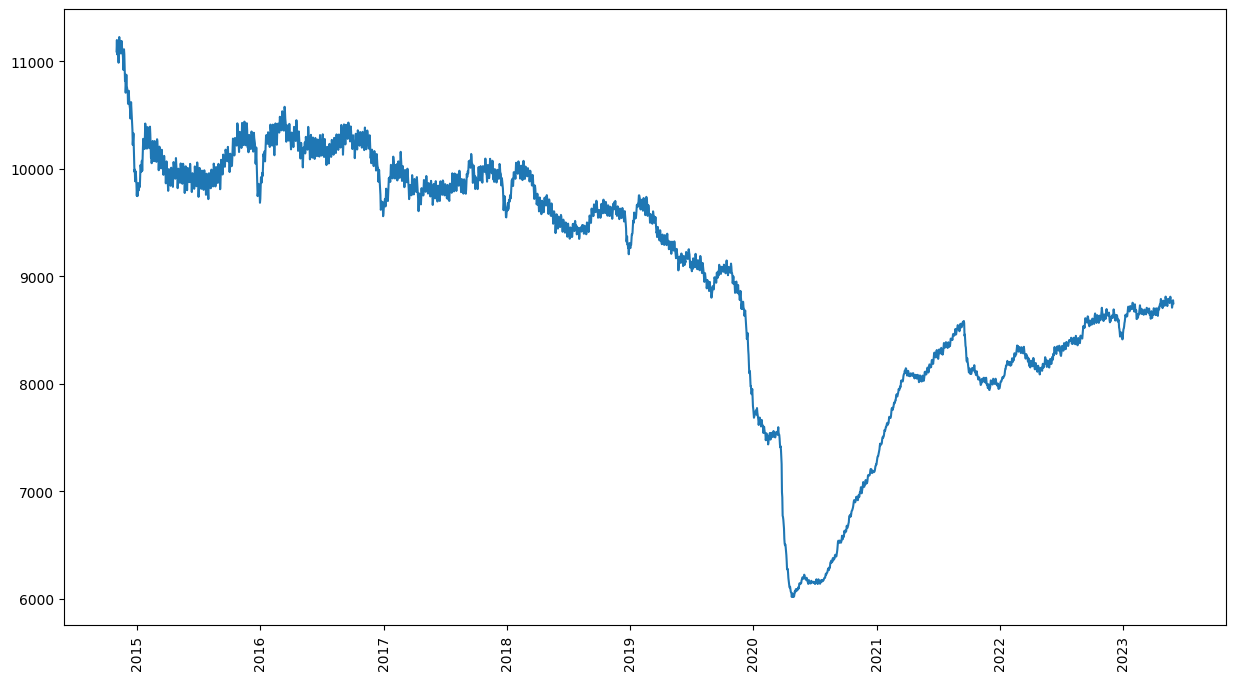

In [72]:
plt.figure(figsize = (15,8))
plt.plot(daily_counts['Daily_Pop'].index,daily_counts['Daily_Pop'])
# plt.plot(daily_counts['Daily_Pop'].index,p_t,color = 'red')
plt.xticks(rotation = 90)
plt.show()

When comparing these outputs to those on Vera's dashboard, we are seeing major discrepencies in daily jaily population numbers. 

### Next Steps

Get a high level understanding of the admissions and discharge trends over the past couple of years to try and inform our future analyses.

Q1: On average is DOC admitting more people or discharging? i.e. Is the jail population net positive or negative?

Q2: What was the jail population as of April 31st? On average how many people a day, week, month would DOC have to admit to reach 7,000 detainees in September 2024?

Q3: How plausible is that metric from occuring?

In [75]:
daily_counts['Daily_Chng'] = daily_counts['Admissions'] - daily_counts['Discharges']

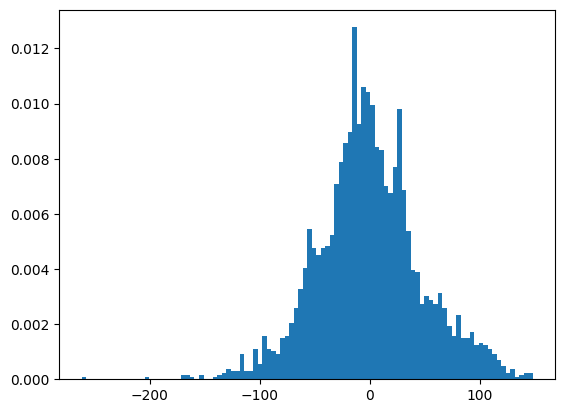

In [76]:
plt.hist(daily_counts['Daily_Chng'], bins = 100, density = True)
plt.show()

In [77]:
daily_counts['Daily_Chng'].describe()

count    3133.000000
mean       -0.721034
std        47.494102
min      -262.000000
25%       -29.000000
50%        -3.000000
75%        27.000000
max       148.000000
Name: Daily_Chng, dtype: float64

In [78]:
daily_counts.reset_index(inplace=True)

In [79]:
daily_counts.head()

,admitted_date,Admissions,Discharges,Daily_Pop,Daily_Chng
0,2014-11-01,128,44,11090.0,84
1,2014-11-02,135,29,11196.0,106
2,2014-11-03,115,249,11062.0,-134
3,2014-11-04,159,130,11091.0,29
4,2014-11-05,237,249,11079.0,-12


In [80]:
#look at monthly admissions, discharges and population change
daily_counts['admitted_date'] = pd.to_datetime(daily_counts['admitted_date'])
daily_counts['mo'] = daily_counts['admitted_date'].dt.month
daily_counts['yr'] = daily_counts['admitted_date'].dt.year
monthly = daily_counts[['yr','mo','Admissions','Discharges']].groupby(by = ['yr','mo']).sum().reset_index()
monthly['Gain/Loss'] = monthly['Admissions'] - monthly['Discharges']
monthly.head()

,yr,mo,Admissions,Discharges,Gain/Loss
0,2014,11,5130,5263,-133
1,2014,12,4001,5127,-1126
2,2015,1,5122,4604,518
3,2015,2,4877,4985,-108
4,2015,3,5334,5544,-210


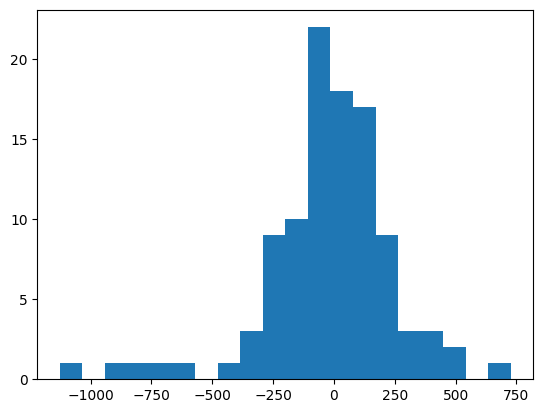

In [81]:
plt.hist(monthly['Gain/Loss'],bins = 20)
plt.show()

In [82]:
monthly['Gain/Loss'].describe()

count     103.000000
mean      -21.932039
std       271.361537
min     -1126.000000
25%      -121.000000
50%       -11.000000
75%       133.000000
max       727.000000
Name: Gain/Loss, dtype: float64

In [83]:
monthly['Year-Mo'] = ['-'.join(i) for i in zip(monthly["yr"].map(str),monthly["mo"].map(str))]

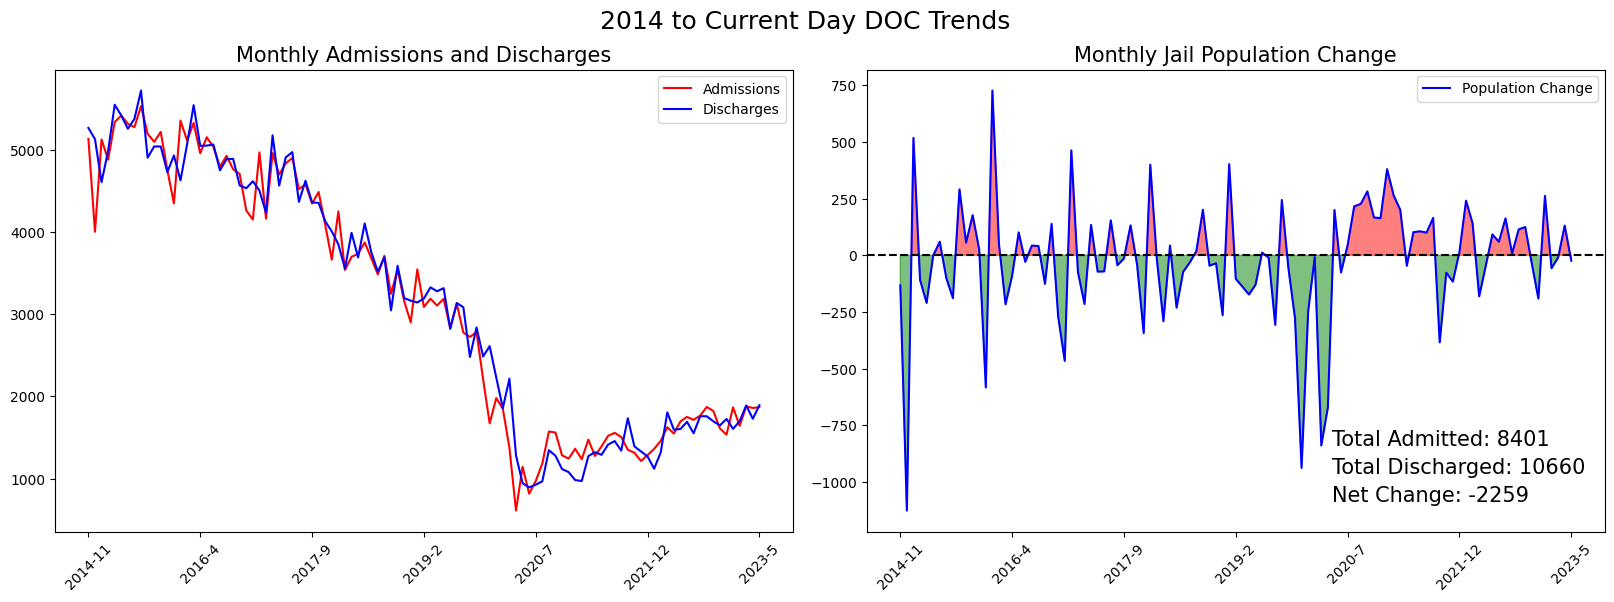

In [95]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Admission and Discharge variables
ax1.plot(monthly['Year-Mo'], monthly['Admissions'], label='Admissions', color='red')
ax1.plot(monthly['Year-Mo'], monthly['Discharges'], label='Discharges', color='blue')
ax1.set_title('Monthly Admissions and Discharges',fontsize = 15)
ax1.legend()

# Plot 2: Gain/Loss variable
ax2.plot(monthly['Year-Mo'], monthly['Gain/Loss'], label='Population Change', color='blue')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.fill_between(monthly['Year-Mo'], monthly['Gain/Loss'], 0, where=(monthly['Gain/Loss'] > 0), interpolate=True, alpha=0.5, color='red')
ax2.fill_between(monthly['Year-Mo'], monthly['Gain/Loss'], 0, where=(monthly['Gain/Loss'] < 0), interpolate=True, alpha=0.5, color='green')
ax2.set_title('Monthly Jail Population Change',fontsize = 15)
ax2.legend()

# Extracting the x-axis values
x_values = monthly['Year-Mo']

# Setting xticks
xticks_idx = range(0, len(x_values), len(x_values)//6)  # Calculate the indices for 7 xticks
xticks_labels = [x_values[i] for i in xticks_idx]  # Get the corresponding labels
ax1.set_xticks(xticks_idx)  # Set the xtick positions
ax1.set_xticklabels(xticks_labels, rotation=45)  # Set the xtick labels with rotation

ax2.set_xticks(xticks_idx)  # Set the xtick positions
ax2.set_xticklabels(xticks_labels, rotation=45)  # Set the xtick labels with rotation

# # Rotate the x-axis tick labels for both subplots
# ax1.tick_params(axis='x', rotation=45)
# ax2.tick_params(axis='x', rotation=45)

# Calculate the areas under the curve
x = np.array(np.arange(1,len(monthly)+1))
y = np.array(monthly['Gain/Loss'])
area_above_zero = sum(y[y > 0])
area_below_zero = sum(y[y < 0])
net_area = area_above_zero - abs(area_below_zero)

# Add text annotations for the areas under the curve
ax2.text(0.63, 0.22, "Total Admitted: " + str(round(area_above_zero, 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
ax2.text(0.63, 0.16, "Total Discharged: " + str(round(abs(area_below_zero), 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
ax2.text(0.63, 0.1, "Net Change: " + str(round(net_area, 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)
fig.suptitle('2014 to Current Day DOC Trends', fontsize=18)
plt.savefig('../Outputs/DOC_2014_CRNT_Admit_Disch_trends.png',bbox_inches = 'tight')
plt.show()


In [87]:
deblasio = monthly[monthly['yr']< 2022]

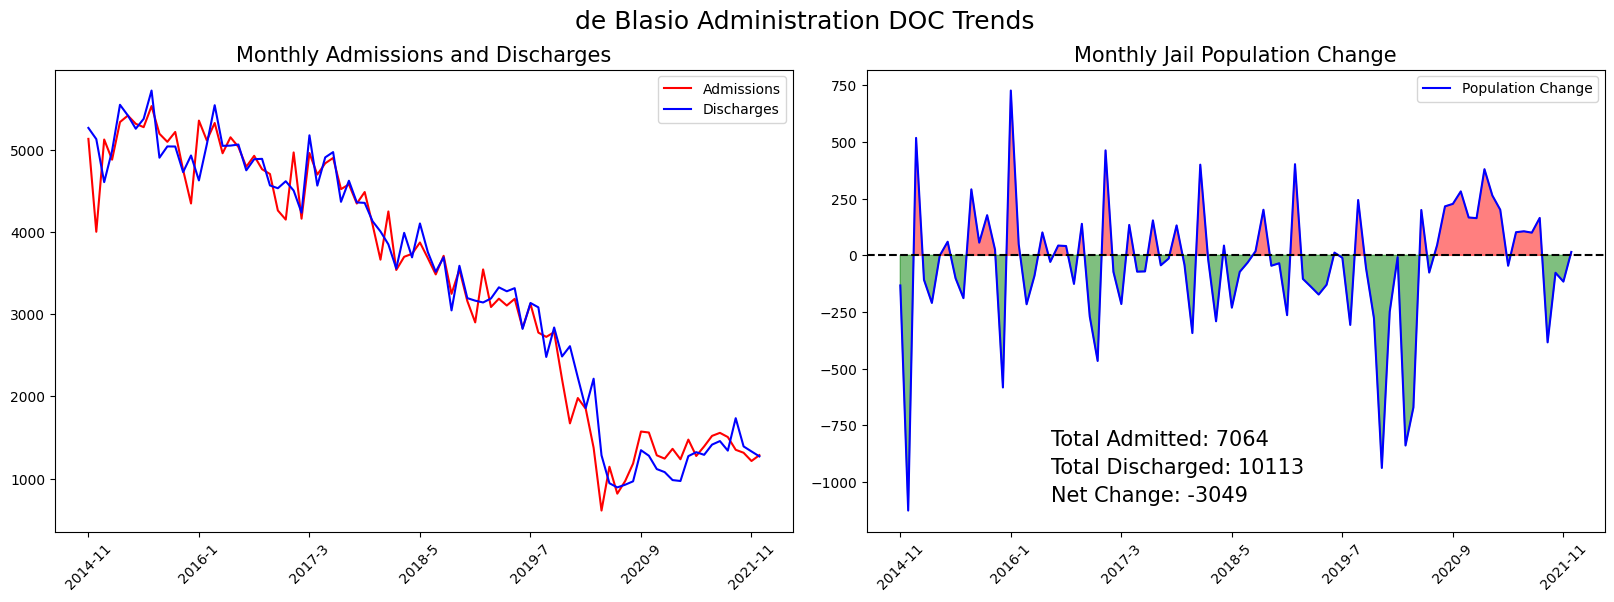

In [90]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Admission and Discharge variables
ax1.plot(deblasio['Year-Mo'], deblasio['Admissions'], label='Admissions', color='red')
ax1.plot(deblasio['Year-Mo'], deblasio['Discharges'], label='Discharges', color='blue')
ax1.set_title('Monthly Admissions and Discharges',fontsize = 15)
ax1.legend()

# Plot 2: Gain/Loss variable
ax2.plot(deblasio['Year-Mo'], deblasio['Gain/Loss'], label='Population Change', color='blue')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.fill_between(deblasio['Year-Mo'], deblasio['Gain/Loss'], 0, where=(deblasio['Gain/Loss'] > 0), interpolate=True, alpha=0.5, color='red')
ax2.fill_between(deblasio['Year-Mo'], deblasio['Gain/Loss'], 0, where=(deblasio['Gain/Loss'] < 0), interpolate=True, alpha=0.5, color='green')
ax2.set_title('Monthly Jail Population Change',fontsize = 15)
ax2.legend()

# Extracting the x-axis values
x_values = deblasio['Year-Mo']

# Setting xticks
xticks_idx = range(0, len(x_values), len(x_values)//6)  # Calculate the indices for 7 xticks
xticks_labels = [x_values[i] for i in xticks_idx]  # Get the corresponding labels
ax1.set_xticks(xticks_idx)  # Set the xtick positions
ax1.set_xticklabels(xticks_labels, rotation=45)  # Set the xtick labels with rotation

ax2.set_xticks(xticks_idx)  # Set the xtick positions
ax2.set_xticklabels(xticks_labels, rotation=45)  # Set the xtick labels with rotation

# # Rotate the x-axis tick labels for both subplots
# ax1.tick_params(axis='x', rotation=45)
# ax2.tick_params(axis='x', rotation=45)

# Calculate the areas under the curve
x = np.array(np.arange(1,len(monthly)+1))
y = np.array(deblasio['Gain/Loss'])
area_above_zero = sum(y[y > 0])
area_below_zero = sum(y[y < 0])
net_area = area_above_zero - abs(area_below_zero)

# Add text annotations for the areas under the curve
ax2.text(0.25, 0.22, "Total Admitted: " + str(round(area_above_zero, 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
ax2.text(0.25, 0.16, "Total Discharged: " + str(round(abs(area_below_zero), 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
ax2.text(0.25, 0.1, "Net Change: " + str(round(net_area, 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)
fig.suptitle('de Blasio Administration DOC Trends', fontsize=18)
plt.savefig('../Outputs/DOC_2014_2021_Admit_Disch_trends.png',bbox_inches = 'tight')
plt.show()

In [91]:
deblasio['Gain/Loss'].describe()

count      86.000000
mean      -35.453488
std       289.920868
min     -1126.000000
25%      -132.250000
50%       -23.500000
75%       133.500000
max       727.000000
Name: Gain/Loss, dtype: float64

### Let's take a look just at the timeframe of the Adam's Administration which began on Jan 1, 2022

In [92]:
adams = monthly[monthly['yr']>= 2022]

In [93]:
adams['Gain/Loss'].describe()

count     17.000000
mean      46.470588
std      130.172538
min     -191.000000
25%      -37.000000
50%       60.000000
75%      131.000000
max      262.000000
Name: Gain/Loss, dtype: float64

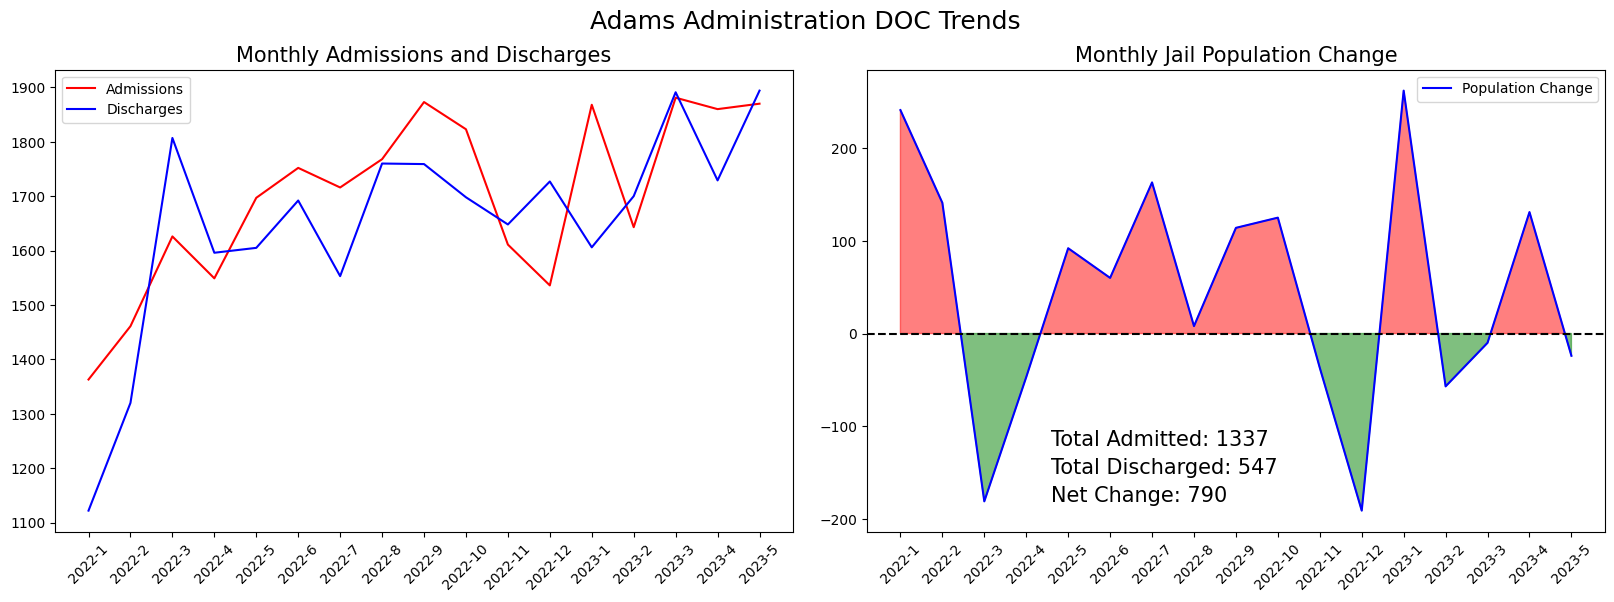

In [94]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Admission and Discharge variables
ax1.plot(adams['Year-Mo'], adams['Admissions'], label='Admissions', color='red')
ax1.plot(adams['Year-Mo'], adams['Discharges'], label='Discharges', color='blue')
ax1.set_title('Monthly Admissions and Discharges',fontsize = 15)
ax1.legend()

# Plot 2: Gain/Loss variable
ax2.plot(adams['Year-Mo'], adams['Gain/Loss'], label='Population Change', color='blue')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.fill_between(adams['Year-Mo'], adams['Gain/Loss'], 0, where=(adams['Gain/Loss'] > 0), interpolate=True, alpha=0.5, color='red')
ax2.fill_between(adams['Year-Mo'], adams['Gain/Loss'], 0, where=(adams['Gain/Loss'] < 0), interpolate=True, alpha=0.5, color='green')
ax2.set_title('Monthly Jail Population Change',fontsize = 15)
ax2.legend()

# Rotate the x-axis tick labels for both subplots
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)

# Calculate the areas under the curve
x = np.array(np.arange(1,len(adams)+1))
y = np.array(adams['Gain/Loss'])
area_above_zero = sum(y[y > 0])
area_below_zero = sum(y[y < 0])
net_area = area_above_zero - abs(area_below_zero)

# Add text annotations for the areas under the curve
ax2.text(0.25, 0.22, "Total Admitted: " + str(round(area_above_zero, 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
ax2.text(0.25, 0.16, "Total Discharged: " + str(round(abs(area_below_zero), 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
ax2.text(0.25, 0.1, "Net Change: " + str(round(net_area, 2)), transform=ax2.transAxes, verticalalignment='top',fontsize = 15)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)
fig.suptitle('Adams Administration DOC Trends', fontsize=18)
plt.savefig('../Outputs/DOC_2022_CRNT_Admit_Disch_trends.png',bbox_inches = 'tight')
plt.show()

In [25]:
adams['Admissions'].sum()-abs(adams['Discharges'].sum())

790

### Now lets look at the distribution of the change in monthly jail population from 2014 to current day to see how plausible it is to experience a certain level of change that would guarantee the jail population reaches +7,000 by Sept 2024

In [26]:
admissions = get_data(admit_url,'admitted_dt','2014-01-01T00:00:00.000', '2023-05-31T00:00:00.000')
admissions.head()

https://data.cityofnewyork.us/resource/6teu-xtgp.json?$select=*&$where=admitted_dt%20between%20'2014-01-01T00:00:00.000'%20and%20'2023-05-31T00:00:00.000'&$limit=500000


,inmateid,admitted_dt,discharged_dt,race,gender,inmate_status_code,top_charge
0,10008773,2018-08-23T10:15:28.000,2018-08-23T11:14:00.000,UNKNOWN,M,DE,VTL 1192.3
1,20037818,2018-08-05T19:13:46.000,2018-08-10T16:46:05.000,UNKNOWN,M,DE,NaN
2,20197484,2018-08-14T02:08:36.000,NaN,BLACK,F,DE,120.05
3,20150289,2018-08-02T00:05:22.000,NaN,UNKNOWN,M,DPV,NaN
4,20122449,2018-08-23T18:34:24.000,NaN,UNKNOWN,M,DE,120.05


In [27]:
discharges = get_data(dis_url,'discharged_dt','2014-01-01T00:00:00.000', '2023-05-31T00:00:00.000')
discharges.head()

https://data.cityofnewyork.us/resource/94ri-3ium.json?$select=*&$where=discharged_dt%20between%20'2014-01-01T00:00:00.000'%20and%20'2023-05-31T00:00:00.000'&$limit=500000


,inmateid,admitted_dt,discharged_dt,race,gender,age,inmate_status_code,top_charge
0,20190778,2018-05-30T15:38:41.000,2018-08-16T06:12:04.000,UNKNOWN,M,25,CS,220.09
1,20130019,2018-02-24T20:15:24.000,2018-08-22T11:24:00.000,UNKNOWN,M,25,DE,NaN
2,41370,2018-07-30T15:58:35.000,2018-08-06T13:21:01.000,BLACK,M,49,DE,NaN
3,20035180,2018-04-30T13:34:00.000,2018-08-01T21:42:02.000,BLACK,M,49,DE,NaN
4,20115029,2018-08-31T00:39:46.000,2018-08-31T13:01:03.000,UNKNOWN,M,38,DE,NaN


In [28]:
## aggregate to monthly

admissions['admitted_dt'] = pd.to_datetime(admissions['admitted_dt'])
discharges['discharged_dt'] = pd.to_datetime(discharges['discharged_dt'])

admissions['admitted_date'] = admissions['admitted_dt'].dt.date
discharges['discharged_date'] = discharges['discharged_dt'].dt.date

admissions['mo'] = admissions['admitted_dt'].dt.month
admissions['yr'] = admissions['admitted_dt'].dt.year

discharges['mo'] = discharges['discharged_dt'].dt.month
discharges['yr'] = discharges['discharged_dt'].dt.year

In [29]:
mn_admits = admissions[['yr','mo','inmateid']].groupby(by = ['yr','mo']).nunique()
mn_admits = mn_admits.rename(columns = {'inmateid':'Admissions'})
mn_discharges = discharges[['yr','mo','inmateid']].groupby(by =  ['yr','mo']).nunique()
mn_discharges = mn_discharges.rename(columns = {'inmateid':'Discharges'})
#merge
mn_counts = mn_admits.merge(mn_discharges, left_index = True, right_index = True)
mn_counts['Pop_Change'] = mn_counts['Admissions'] - mn_counts['Discharges']
mn_counts.head()

Admissions  Discharges  Pop_Change
yr   mo                                    
2014 1         5954        5811         143
     2         5232        5417        -185
     3         6136        6061          75
     4         5677        6005        -328
     5         6005        6130        -125

In [30]:
mn_counts['Pop_Change'].describe()

count     113.000000
mean      -39.026549
std       256.141857
min     -1133.000000
25%      -140.000000
50%       -29.000000
75%       106.000000
max       650.000000
Name: Pop_Change, dtype: float64

In [31]:
#introduce a custom function performing distribution analysis
def distribution_analysis(x, log_scale = False, fit_distribution = 'None', bins = 50, vis_means = True, vis_curve = True, print_outputs = True):
    #x - array of observations
    #log_scale - analyze distribution of log(x) if True
    #fit_distribution - fit the distribution ('normal', 'gev' or 'pareto') or do nothing if 'None'
    #bins - how many bins to use for binning the data
    #vis_means - show mean and std lines if True
    #vis_curve - show interpolated distribution curve over the histogram bars if True
    #print_outputs - print mean, std and percentiles
    
    if log_scale: 
        x1 = np.log10(x) #convert data to decimal logarithms
        xlabel = 'log(values)' #reflect in x labels
    else:
        x1 = x #leave original scale 
        xlabel = 'values'
    mu = x1.mean() #compute the mean
    if log_scale: #if logscale, output all three - log mean, its original scale and original scale mean
        print('Log mean = {:.2f}({:.2f}), mean = {:.2f}'.format(mu,10**mu,x.mean()))
    else:
        print('Mean = {:.2f}'.format(mu)) #otherwise print mean
    sigma = x1.std() #compute and output standard deviation 
    print('Standard deviation = {:.2f}'.format(sigma))
    for p in [1,5,25,50,75,95,99]: #output percentile values
        print('{:d} percentile = {:.2f}'.format(p,np.percentile(x,p)))
    
    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x1, hist=True, kde=vis_curve, 
        bins=bins,color = 'darkblue', 
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})
    
    #show vertical lines for mean and std if vis_means = True
    if vis_means:
        plt.axvline(mu, color='r', ls='--', lw=2.0)
        plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
        plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)
        
    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
    #(to make sure the fitted distribution would not affect it)
    
    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
    pars = None #fitted distribution parameters
    
    #fit and visualize the theoretic distribution
    if fit_distribution == 'normal':
        pars = norm.fit(x1)
        plt.plot(h,norm.pdf(h,*pars),'r')
    elif fit_distribution == 'gev':
        pars = gev.fit(x1)
        plt.plot(h,gev.pdf(h,*pars),'r')
    elif fit_distribution == 'pareto':
        pars = pareto.fit(x1)
        plt.plot(h,pareto.pdf(h,*pars),'r')
    
    plt.xlabel(xlabel) #add x label 
    plt.ylim(ylim) #restore the y-range of original distribution density values 
    plt.show()
    return mu, sigma,pars

#check if the distribution is normal using one-sample KS test and sample mean-std
def is_normal(x):
        return stats.kstest(x,'norm',args=(x.mean(),x.std()))

Mean = -39.03
Standard deviation = 256.14
1 percentile = -913.04
5 percentile = -425.00
25 percentile = -140.00
50 percentile = -29.00
75 percentile = 106.00
95 percentile = 303.00
99 percentile = 479.16


C:\Users\emjoh\AppData\Local\Temp\ipykernel_6180\1408217842.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, hist=True, kde=vis_curve,


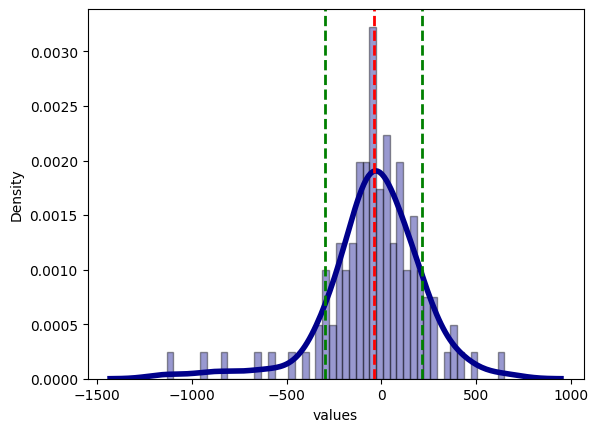

(-39.02654867256637, 256.14185732634394, None)

In [32]:
distribution_analysis(mn_counts['Pop_Change'])

In [33]:
is_normal(mn_counts['Pop_Change'])

KstestResult(statistic=0.1143746683589254, pvalue=0.0960707908150028, statistic_location=-154, statistic_sign=-1)

Based on the results of the KS test above, which is testing for normality, we cannot reject the null hypothesis that the distribution is normal with the sample mean and standard deviation.

In [34]:
#let's standardize and test again
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x = np.asarray(mn_counts['Pop_Change']).reshape(-1,1)
sc.fit(x)
x_scaled = sc.transform(x)

Mean = 0.00
Standard deviation = 1.00
1 percentile = -3.43
5 percentile = -1.51
25 percentile = -0.40
50 percentile = 0.04
75 percentile = 0.57
95 percentile = 1.34
99 percentile = 2.03


C:\Users\emjoh\AppData\Local\Temp\ipykernel_6180\1408217842.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, hist=True, kde=vis_curve,


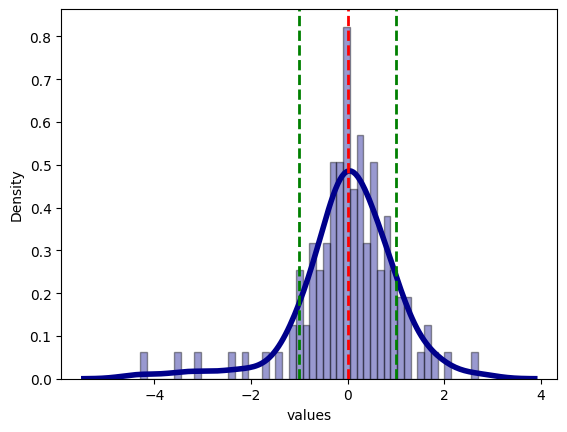

(3.0703070371270924e-18, 0.9999999999999999, None)

In [35]:
distribution_analysis(x_scaled)

In [36]:
x_scaled.shape

(113, 1)

In [37]:
mn_counts['Pop_Change'].shape

(113,)

In [38]:
is_normal(x_scaled.reshape(mn_counts['Pop_Change'].shape))

KstestResult(statistic=0.11365378219527539, pvalue=0.0997684740596424, statistic_location=-0.45086572828786287, statistic_sign=-1)

In [39]:
# Set the parameters
mean = -39.14
std_dev = 257.29

# Create the normal distribution
np.random.seed(42)  # Set a seed for reproducibility
normal_dist = np.random.normal(loc=mean, scale=std_dev, size=(100000, 15))

# Create a dataframe with the random samples
random_samps = pd.DataFrame(normal_dist)

# Calculate the sum across each row
random_samps['Net_Change'] = random_samps.sum(axis=1)

# Display the dataframe
random_samps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Net_Change
0,88.659584,-74.714022,127.503784,352.720352,-99.385322,-99.381098,367.175665,158.313281,-159.931065,100.455274,-158.372738,-158.967608,23.114473,-531.407874,-482.944109,-547.161423
1,-183.810958,-299.731319,41.712696,-272.765514,-402.511619,337.956772,-97.229984,-21.765668,-405.713461,-179.204231,-10.600727,-335.279138,57.523343,-193.678329,-114.189885,-2079.288022
2,-193.953094,437.432654,-42.612701,-311.278445,172.492580,-353.250863,14.598514,-543.343526,-380.868989,11.510427,150.860066,4.951345,-68.895147,-116.610970,-419.548923,-1638.517069
3,-224.348716,-157.657749,232.846978,49.269550,-492.752602,44.243564,-138.217820,-213.305261,118.238192,226.125867,200.469062,-255.062277,-118.697252,46.090768,211.858006,-470.899690
4,-162.426740,-86.908198,-323.788925,-346.912002,169.914769,309.806997,-57.667484,219.058979,53.905333,-205.122862,53.843475,356.581428,-48.357682,363.427166,-713.174218,-417.819963


In [40]:
random_samps['Net_Change'].describe()

count    100000.000000
mean       -592.920238
std         994.858395
min       -5316.206720
25%       -1263.057908
50%        -585.816346
75%          79.599121
max        3577.118698
Name: Net_Change, dtype: float64

In [41]:
#lets try this with a standard normal distribution and the standardscaler we defined based on our data
# Set the parameters
mean = 0.00
std_dev = 1.00

# Create the normal distribution
np.random.seed(42)  # Set a seed for reproducibility
std_normal_dist = np.random.normal(loc=mean, scale=std_dev, size=(100000, 15))

# Create a dataframe with the random samples
std_random_samps = pd.DataFrame(std_normal_dist)

random_samps_reversed = pd.DataFrame(sc.inverse_transform(std_random_samps), columns=std_random_samps.columns)

# Calculate the sum across each row
random_samps_reversed['Net_Change'] = random_samps_reversed.sum(axis=1)

# Display the dataframe
random_samps_reversed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Net_Change
0,87.638525,-74.284771,126.137894,349.355154,-98.737057,-98.732870,363.682143,156.673887,-158.745319,99.329500,-157.200826,-157.790415,22.675275,-526.924429,-478.890890,-545.814198
1,-182.413224,-297.304529,41.108396,-270.578107,-399.172421,334.722634,-96.600853,-21.806453,-402.345839,-177.847392,-10.740626,-332.536780,56.778688,-192.192999,-113.410196,-2064.339699
2,-192.465326,433.315442,-42.468422,-308.749148,170.727313,-350.348965,14.234914,-538.754125,-377.721917,11.174241,149.286836,4.673386,-68.517551,-115.809788,-416.058480,-1627.481588
3,-222.591118,-156.492184,230.545928,48.598166,-488.612310,43.616798,-137.224828,-211.645698,116.954555,223.884482,198.455439,-253.032025,-117.877550,45.447603,209.743280,-470.229462
4,-161.218839,-86.370696,-321.148569,-344.066376,168.172385,306.822752,-57.389559,216.880329,53.192796,-203.535936,53.131487,353.181954,-48.162402,359.966921,-707.077184,-417.620937


In [42]:
random_samps_reversed['Net_Change'].describe()

count    100000.000000
mean       -591.166800
std         986.026770
min       -5272.523402
25%       -1255.355479
50%        -584.125971
75%          75.382424
max        3541.853582
Name: Net_Change, dtype: float64

In [43]:
#daily jail pop as of May 30, 2023 is 6,049
random_samps_reversed['Proj_Pop'] = 6049 + random_samps_reversed['Net_Change']
random_samps['Proj_Pop'] = 6049 + random_samps['Net_Change']

In [44]:
random_samps_reversed['Proj_Pop'].describe()

count    100000.000000
mean       5457.833200
std         986.026770
min         776.476598
25%        4793.644521
50%        5464.874029
75%        6124.382424
max        9590.853582
Name: Proj_Pop, dtype: float64

In [45]:
random_samps['Proj_Pop'].describe()

count    100000.000000
mean       5456.079762
std         994.858395
min         732.793280
25%        4785.942092
50%        5463.183654
75%        6128.599121
max        9626.118698
Name: Proj_Pop, dtype: float64

Mean = 5457.83
Standard deviation = 986.03
1 percentile = 3159.71
5 percentile = 3827.16
25 percentile = 4793.64
50 percentile = 5464.87
75 percentile = 6124.38
95 percentile = 7074.59
99 percentile = 7752.41


C:\Users\emjoh\AppData\Local\Temp\ipykernel_6180\1408217842.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, hist=True, kde=vis_curve,


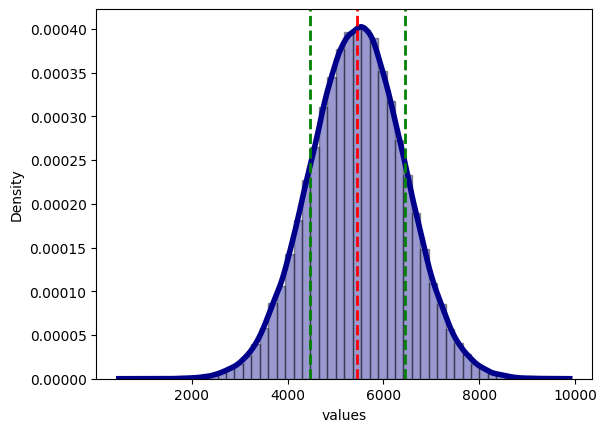

(5457.833199841617, 986.0267704647118, None)

In [46]:
distribution_analysis(random_samps_reversed['Proj_Pop'])

Mean = 5456.08
Standard deviation = 994.86
1 percentile = 3137.37
5 percentile = 3810.80
25 percentile = 4785.94
50 percentile = 5463.18
75 percentile = 6128.60
95 percentile = 7087.32
99 percentile = 7771.20


C:\Users\emjoh\AppData\Local\Temp\ipykernel_6180\1408217842.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, hist=True, kde=vis_curve,


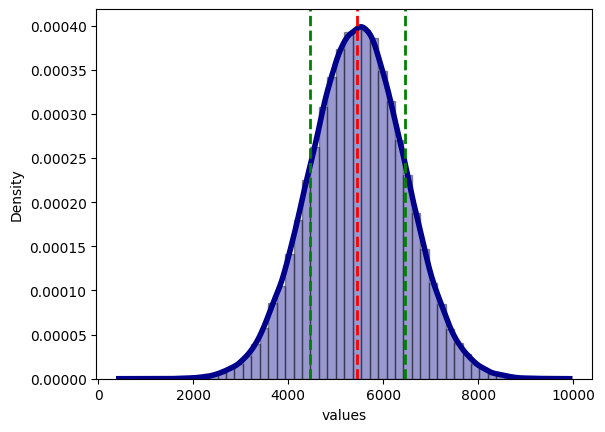

(5456.079762117363, 994.8583952735919, None)

In [47]:
distribution_analysis(random_samps['Proj_Pop'])

In [48]:
#what is the probability this number is greater than or equal to 7,000
len(random_samps['Proj_Pop'][random_samps['Proj_Pop']>= 7000])/len(random_samps['Proj_Pop'])*100

5.984

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import norm, lognorm, expon, gamma, beta, uniform, t, weibull_min
from scipy.optimize import minimize
from scipy.stats import kstest


# Define the list of PDFs you want to fit
pdf_list = [
    norm, lognorm, expon, gamma, beta, uniform, t, weibull_min
]

# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Distribution', 'Parameters', 'AIC'])

# Fit each PDF to the data and collect the results
for pdf in pdf_list:
    # Fit the PDF to your data using maximum likelihood estimation
    params = minimize(lambda params: -pdf.logpdf(x_scaled, *params).sum(), x0=pdf.fit(x_scaled)).x
    
    # Compute the AIC value
    k = len(params)  # Number of parameters in the PDF
    n = len(x_scaled)  # Number of data points
    log_likelihood = np.sum(pdf.logpdf(x_scaled, *params))
    aic = -2 * log_likelihood + 2 * k
    
    # Perform the KS test
    ks_result = kstest(x_scaled.reshape(mn_counts['Pop_Change'].shape), pdf.name, args=params)
    p_value = ks_result.pvalue
    
    # Append the results to the dataframe
    new_row = pd.DataFrame({
        'Distribution': [pdf.name],
        'Parameters': [params],
        'AIC': [aic],
        'KS Test': [p_value]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Sort the dataframe by the AIC value in ascending order
results_df.sort_values(by='AIC', inplace=True)

# Print the results
results_df

C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:489: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:575: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x[i] - x0[i]  # Recompute dx as exactly representable number.
C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:489: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:575: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x[i] - x0[i]  # Recompute dx as exactly representable number.
C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:489: RuntimeWarning: invalid value encountered in subtract
  dx = 

,Distribution,Parameters,AIC,KS Test
6,t,"[2.9137579303939654, 0.07565972544047068, 0.62...",302.886671,0.968050
4,beta,"[5767406.212035202, 20.884671363815542, -12426...",319.930250,0.287410
7,weibull_min,"[8581.009329209359, -7795.630456516394, 7796.0...",324.413841,0.242422
0,norm,"[3.0703070371270924e-18, 0.9999999999999999]",324.680109,0.099768
1,lognorm,"[0.0010178894372784206, -982.9899258337726, 98...",326.811568,0.098527
3,gamma,"[489.0145914019488, -22.807089448326842, 0.046...",331.020499,0.059240
2,expon,"[-inf, nan]",NaN,NaN
5,uniform,"[-inf, nan]",NaN,NaN


C:\Users\emjoh\AppData\Local\Temp\ipykernel_6180\2538988135.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_scaled, hist=True, kde=True,


Mean = 0.00
Standard deviation = 1.00
1 percentile = -3.43
5 percentile = -1.51
25 percentile = -0.40
50 percentile = 0.04
75 percentile = 0.57
95 percentile = 1.34
99 percentile = 2.03


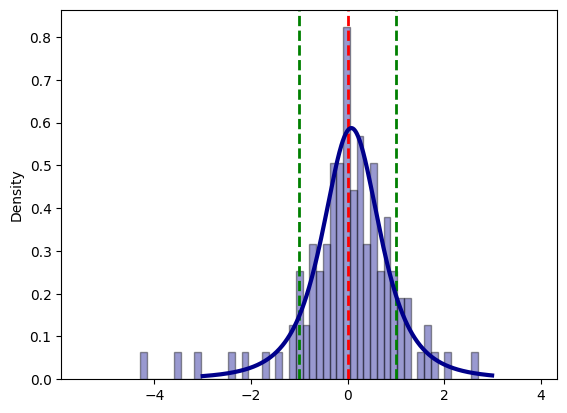

In [50]:
mu = x_scaled.mean() #compute the mean
print('Mean = {:.2f}'.format(mu)) #otherwise print mean
sigma = x_scaled.std() #compute and output standard deviation 
print('Standard deviation = {:.2f}'.format(sigma))
for p in [1,5,25,50,75,95,99]: #output percentile values
    print('{:d} percentile = {:.2f}'.format(p,np.percentile(x_scaled,p)))
    
#visualize histogram and the interpolated line (if vis_curve=True) using seaborn
sns.distplot(x_scaled, hist=True, kde=True, 
                bins=50,color = 'darkblue', 
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 0})
plt.axvline(mu, color='r', ls='--', lw=2.0)
plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)

ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
#(to make sure the fitted distribution would not affect it)

h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
pars = list(results_df.iloc[0]['Parameters']) #fitted distribution parameters

plt.plot(h,t.pdf(h,*pars),color = 'darkblue',linewidth = 3)

plt.ylim(ylim) #restore the y-range of original distribution density values 
plt.show()

In [51]:
#redo sampling with this distribution

#lets try this with a standard normal distribution and the standardscaler we defined based on our data
# Set the parameters
pars = list(results_df.iloc[0]['Parameters']) #fitted distribution parameters

df = pars[0]
loc = pars[1]
scale = pars[2]

# Create the normal distribution
np.random.seed(42)  # Set a seed for reproducibility
t_dist = t.rvs(df=df, loc=loc, scale=scale, size=(100000, 15))
# Create a dataframe with the random samples
std_random_samps = pd.DataFrame(t_dist)

random_samps_reversed = pd.DataFrame(sc.inverse_transform(std_random_samps), columns=std_random_samps.columns)

# Calculate the sum across each row
random_samps_reversed['Net_Change'] = random_samps_reversed.sum(axis=1)
random_samps_reversed['Avg_Change'] = random_samps_reversed.mean(axis=1)


# Display the dataframe
random_samps_reversed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Net_Change,Avg_Change
0,76.556975,-194.441458,187.338759,-157.831208,154.811597,374.232130,-417.065205,-107.895931,-113.506931,-93.347754,-74.546357,-116.762352,288.743028,292.636044,104.047636,202.968973,25.371122
1,-534.086266,-74.046081,-212.410986,-114.018310,53.235641,-197.164103,-194.913041,-426.932078,112.704121,72.417053,213.314354,-356.253332,-187.885768,-53.691876,-124.163054,-2023.893727,-252.986716
2,-209.429673,37.338078,-96.489593,209.786252,-169.606680,247.155216,-18.692583,-102.485204,-44.177770,-118.548900,-372.097552,3.380078,-50.184638,42.108429,131.004927,-510.939614,-63.867452
3,-104.301847,28.758527,-80.785097,3.670851,-17.741197,-176.163551,101.920357,-186.449959,-70.534711,4.876527,-84.793530,14.158358,360.177249,19.166538,9.059461,-178.982025,-22.372753
4,58.113484,45.634357,-182.761260,-283.009952,125.747169,-166.841631,-271.379073,159.481752,-18.392300,-278.994171,-176.855118,-36.178547,-425.023227,-238.382284,6.722055,-1682.118745,-210.264843


In [52]:
random_samps_reversed['Net_Change'].describe()

count    100000.000000
mean       -291.746645
std        1092.839989
min      -23263.591557
25%        -936.832240
50%        -295.302516
75%         351.407302
max       28488.687315
Name: Net_Change, dtype: float64

In [53]:
random_samps_reversed['Avg_Change'].describe()

count    100000.000000
mean        -36.468331
std         136.604999
min       -2907.948945
25%        -117.104030
50%         -36.912814
75%          43.925913
max        3561.085914
Name: Avg_Change, dtype: float64

In [54]:
#daily jail pop as of May 30, 2023 is 6,049
random_samps_reversed['Proj_Pop'] = 6049 + random_samps_reversed['Net_Change']

Mean = 5757.25
Standard deviation = 1092.84
1 percentile = 3087.04
5 percentile = 4077.14
25 percentile = 5112.17
50 percentile = 5753.70
75 percentile = 6400.41
95 percentile = 7445.15
99 percentile = 8439.05


C:\Users\emjoh\AppData\Local\Temp\ipykernel_6180\1408217842.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, hist=True, kde=vis_curve,


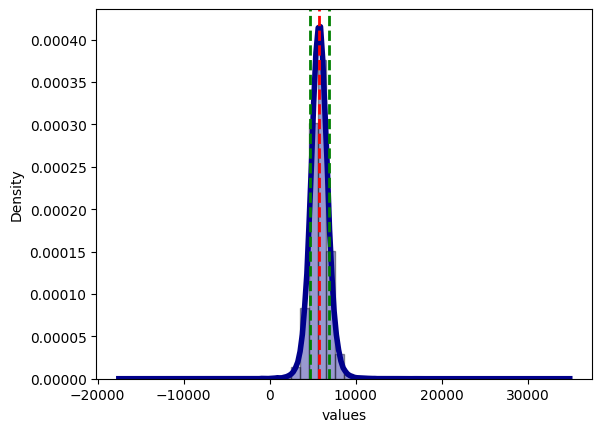

(5757.253355388899, 1092.8399893868254, None)

In [55]:
distribution_analysis(random_samps_reversed['Proj_Pop'])

Mean = 5501.98
Standard deviation = 2049.07
1 percentile = 495.33
5 percentile = 2351.76
25 percentile = 4292.44
50 percentile = 5495.31
75 percentile = 6707.89
95 percentile = 8666.79
99 percentile = 10530.35


C:\Users\emjoh\AppData\Local\Temp\ipykernel_6180\1408217842.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, hist=True, kde=vis_curve,


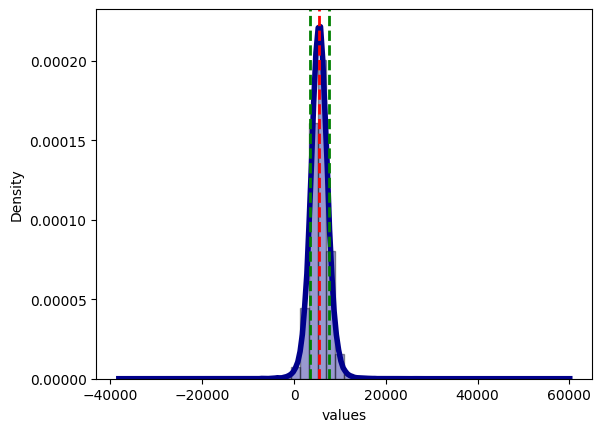

(5501.975041354185, 2049.0749801002976, None)

In [56]:
random_samps_reversed['Proj_Pop_2'] = 6049 + random_samps_reversed['Avg_Change']*15
distribution_analysis(random_samps_reversed['Proj_Pop_2'])

In [57]:
#what is the probability this number is greater than or equal to 7,000
len(random_samps_reversed['Proj_Pop'][random_samps_reversed['Proj_Pop']>= 7000])/len(random_samps_reversed['Proj_Pop'])*100

10.484

In [58]:
len(random_samps_reversed['Proj_Pop_2'][random_samps_reversed['Proj_Pop_2']>= 7000])/len(random_samps_reversed['Proj_Pop_2'])*100

20.308

In [59]:
#what is the probability this avg change is above the 63.4/mo threshold
len(random_samps_reversed['Avg_Change'][random_samps_reversed['Avg_Change']>= 63])/len(random_samps_reversed['Avg_Change'])*100

20.41

In [60]:
# Calculate the sample mean and standard deviation
sample_mean = random_samps_reversed['Proj_Pop'].mean()
sample_std = random_samps_reversed['Proj_Pop'].std()

# Calculate the number of samples
n = len(random_samps_reversed)

# Set the confidence level
confidence_level = 0.95

# Calculate the t-value for the given confidence level and degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df=n-1)

# Calculate the margin of error
margin_of_error = t_value * (sample_std / np.sqrt(n))

# Calculate the confidence interval
lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

# Display the confidence interval
print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")

95% Confidence Interval: [5750.479905439391, 5764.026805338407]


In [61]:
sample_mean

5757.253355388899

In [62]:
# Calculate the sample mean and standard deviation
sample_mean = random_samps_reversed['Proj_Pop_2'].mean()
sample_std = random_samps_reversed['Proj_Pop_2'].std()

# Calculate the number of samples
n = len(random_samps_reversed)

# Set the confidence level
confidence_level = 0.95

# Calculate the t-value for the given confidence level and degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df=n-1)

# Calculate the margin of error
margin_of_error = t_value * (sample_std / np.sqrt(n))

# Calculate the confidence interval
lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

# Display the confidence interval
print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")

95% Confidence Interval: [5489.274822698858, 5514.675260009512]
